In [37]:
%matplotlib notebook
import numpy as np
from elastica import *
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
class RodSimulator(
    BaseSystemCollection, Constraints, Connections, Forcing, CallBacks
):
    pass
# Callback functions
# Add call backs
class RodCallback(CallBackBaseClass):
    """
    Call back function for testing joints
    """

    def __init__(self, step_skip: int, callback_params: dict):
        CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    def make_callback(self, system, time, current_step: int):
        if current_step % self.every == 0:
            self.callback_params["time"].append(time)
            self.callback_params["step"].append(current_step)
            self.callback_params["position"].append(system.position_collection.copy())
            self.callback_params["velocity"].append(system.velocity_collection.copy())
            return

In [52]:
stretch_sim = RodSimulator()

# setting up test params
n_elem = 10
start = np.zeros((3,))
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
roll_direction = np.cross(direction, normal)
base_length = 3.0
base_radius = 0.25
base_area = np.pi * base_radius ** 2
density = 5000
nu = 0.1
E = 1e6
# For shear modulus of 1e4, nu is 99!
poisson_ratio = 99
shear_modulus = E / (poisson_ratio + 1.0)

# Create rod 1
rod1 = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    shear_modulus=shear_modulus,
    poisson_ratio=poisson_ratio
)

stretch_sim.append(rod1)
# stretch_sim.constrain(rod1).using(
#     OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
# )

final_time = 1
end_force = np.array([0.0, 0.0, 15.0])
# stretch_sim.add_forcing_to(rod1).using(
#     EndpointForces, 0.0 * end_force, end_force, ramp_up_time=final_time/2.0
# )
stretch_sim.add_forcing_to(rod1).using(
    GravityForces
)
pp_list_rod1 = defaultdict(list)
stretch_sim.collect_diagnostics(rod1).using(
    RodCallback, step_skip=1000, callback_params=pp_list_rod1
)

stretch_sim.finalize()

In [53]:
timestepper = PositionVerlet()
# timestepper = PEFRL()

dl = base_length / n_elem
dt = 1e-5
total_steps = int(final_time / dt)
print("Total steps", total_steps)
integrate(timestepper, stretch_sim, final_time, total_steps)

Total steps 99999


100%|█████████████████████████████████████████████████████████████████████| 99999/99999 [00:05<00:00, 19194.28it/s]

Final time of simulation is :  0.9999999999973068


In [54]:
max_timesteps = len(pp_list_rod1['time'])
print(max_timesteps)

100


<IPython.core.display.Javascript object>


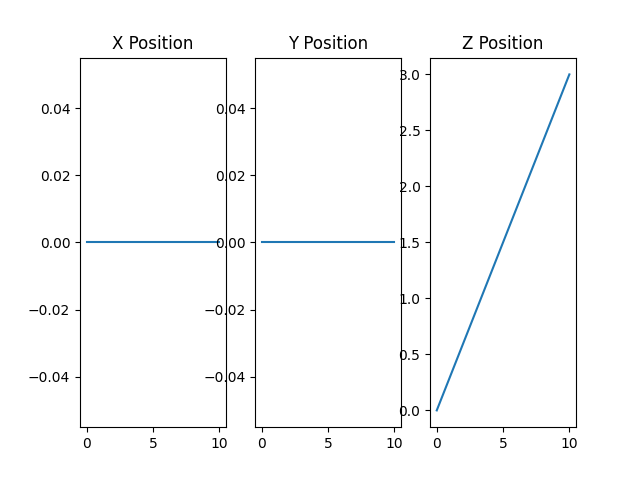

Text(0.5, 1.0, 'Z Position')

In [55]:
timestep = 0
x_vals = pp_list_rod1['position'][timestep][0]
y_vals = pp_list_rod1['position'][timestep][1]
z_vals = pp_list_rod1['position'][timestep][2]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

ax1.plot(x_vals)
ax1.set_title("X Position")

ax2.plot(y_vals)
ax2.set_title("Y Position")
ax3.plot(z_vals)
ax3.set_title("Z Position")


<IPython.core.display.Javascript object>


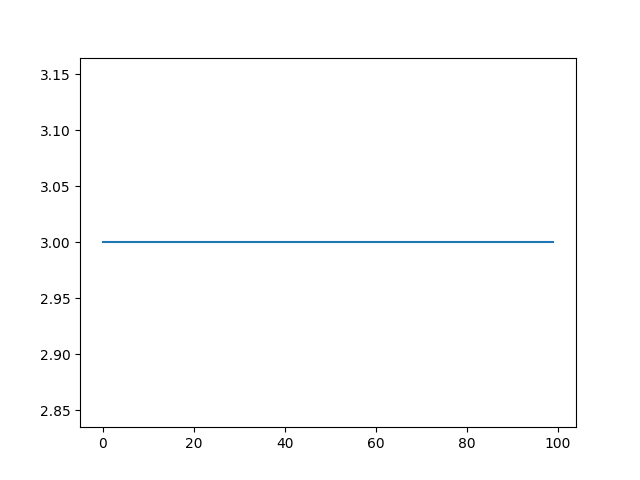

100
3.0


In [56]:
end_node_pose = []
for timestep in range(max_timesteps):
    end_node_pose.append(pp_list_rod1['position'][timestep][2][-1])
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(end_node_pose)
print(max_timesteps)
print(sum(end_node_pose[max_timesteps//2:])/(max_timesteps/2))

<IPython.core.display.Javascript object>


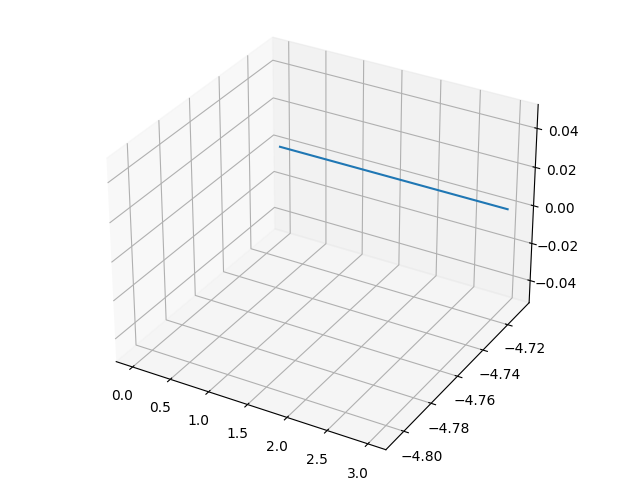

/tmp/ipykernel_2000/3755628282.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


In [63]:
fig = plt.figure()
ax = p3.Axes3D(fig)
line, = ax.plot(z_vals, y_vals, x_vals)
def animate(timestep):
#     line.remove()
    global line
    if timestep != len(pp_list_rod1['position']) -1:
        print(timestep)
        line.remove()
    x_vals = pp_list_rod1['position'][timestep][0]
    y_vals = pp_list_rod1['position'][timestep][1]
    z_vals = pp_list_rod1['position'][timestep][2]
    # line.set(np.sin(x + i / 50))  # update the data.
    line, = ax.plot(z_vals, y_vals, x_vals)
    
    return line
ani = animation.FuncAnimation(
    fig, animate, interval=20)

plt.show()